In [45]:
# STEP 1: Setup and imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Button, HBox, VBox, Output

# CONFIGURATION - Change these values for each user
USER_ID = 55  # Change this for each user
TCX_FILE = f'data/{USER_ID}-d.tcx'
CHART_IMAGE = f'charts_cropped/user_{USER_ID}.png'
OUTPUT_CSV = f'output/processed/user_{USER_ID}_station_data.csv'

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')

# Add scripts directory to path
sys.path.append('scripts')
from parse_tcx import parse_tcx_to_df

# Load data - handling potential parsing issues for low quality data
try:
    result = parse_tcx_to_df(TCX_FILE)
    if len(result) == 4:  # Handle case where calories_burned might be missing
        df, session_total_sec, sessions_avg_hr, session_max_hr = result
        calories_burned = None
        print("Note: Calories data not available in TCX file")
    else:
        df, session_total_sec, sessions_avg_hr, session_max_hr, calories_burned = result
    
    session_duration_min = session_total_sec / 60
    print(f"Data loaded successfully: {len(df)} data points over {session_duration_min:.2f} minutes")
    print(f"Average HR: {sessions_avg_hr:.1f} bpm, Maximum HR: {session_max_hr} bpm")
    if calories_burned:
        print(f"Calories: {calories_burned}")
    
    # Data quality assessment
    data_rate = len(df) / session_duration_min
    print(f"\nDATA QUALITY ASSESSMENT:")
    print(f"Recording rate: {data_rate:.1f} data points per minute")
    if session_duration_min < 45:
        print("⚠️  WARNING: Session appears incomplete - data stops before expected 50-minute duration")
    if data_rate < 3:
        print("⚠️  WARNING: Very sparse data recording detected")
        
except Exception as e:
    print(f"Error loading data: {e}")
    # Create empty dataframe for error cases
    df = pd.DataFrame()
    session_total_sec = 0
    sessions_avg_hr = 0
    session_max_hr = 0
    calories_burned = None
    session_duration_min = 0
    
# Load background image
try:
    img = mpimg.imread(CHART_IMAGE)
    print(f"Background image loaded successfully from {CHART_IMAGE}")
except Exception as e:
    print(f"Error loading background image: {e}")


Data loaded successfully: 145 data points over 34.17 minutes
Average HR: 131.8 bpm, Maximum HR: 167 bpm
Calories: 232

DATA QUALITY ASSESSMENT:
Recording rate: 4.2 data points per minute
⚠️  WARNING: Session appears incomplete - data stops before expected 50-minute duration
Background image loaded successfully from charts_cropped/user_55.png


In [46]:
# Load user metadata
import pandas as pd
try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == USER_ID]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {USER_ID}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        print(f"No metadata found for user {USER_ID}")
        age = gender = height_cm = weight_kg = champ_number = None
except Exception as e:
    print(f"Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None


Loaded metadata for user 55: age=None, gender= , height=Nonecm, weight=Nonekg, champ=4


In [47]:
# Global variables to store alignment parameters
# These will be set by the interactive alignment tool and used by the station visualization
global_x_offset = 0
global_x_scale = 1
global_y_min = 0
global_y_max = 200
global_alpha = 0.5


In [48]:
# Create output directories for plots
import os
plots_dir = f'output/plots/user_55'
os.makedirs(plots_dir, exist_ok=True)
print(f"Created plots directory: {plots_dir}")


Created plots directory: output/plots/user_55


In [49]:
# Initialize global alignment parameters
# These will be updated by the interactive alignment tool
current_x_offset = -0.8  # Default starting values
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6


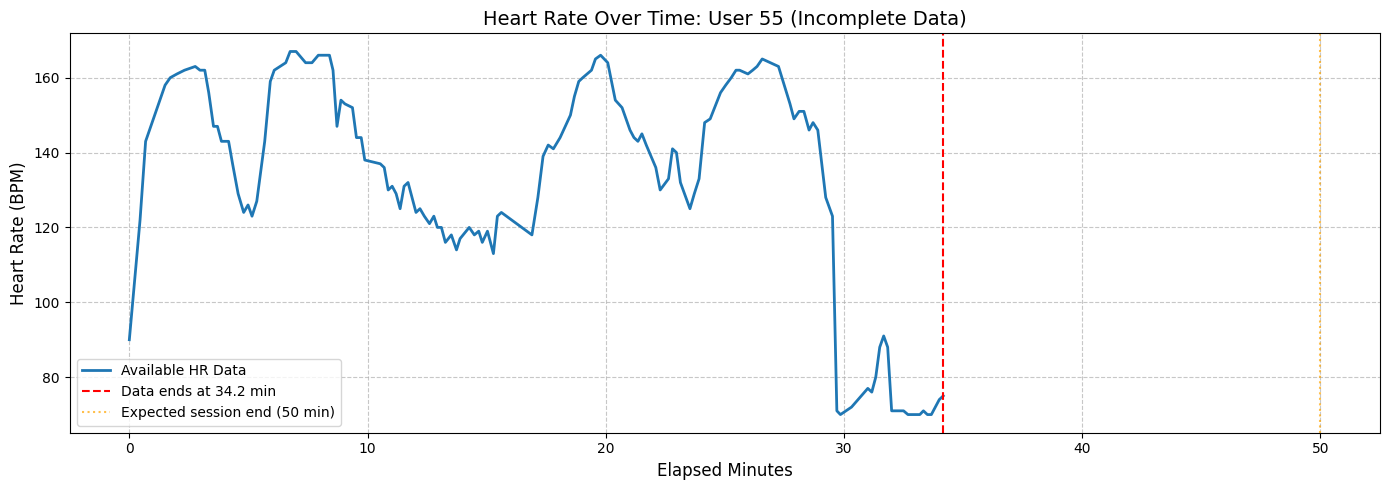

Maximum Heart Rate Details:
                   timestamp  heart_rate                start_time  \
25 2025-04-06 12:38:10+00:00         167 2025-04-06 12:31:25+00:00   
26 2025-04-06 12:38:25+00:00         167 2025-04-06 12:31:25+00:00   

    elapsed_min  
25         6.75  
26         7.00  

DATA QUALITY SUMMARY:
Available data: 34.2 minutes
Expected session: 50 minutes
Missing data: 15.8 minutes (31.7%)


In [50]:
# STEP 2: Visualize heart rate data with data quality indicators
if not df.empty:
    plt.figure(figsize=(14,5))
    plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2, label='Available HR Data')
    
    # Add vertical line to show where data ends vs expected session length
    if session_duration_min < 45:
        plt.axvline(x=session_duration_min, color='red', linestyle='--', 
                   label=f'Data ends at {session_duration_min:.1f} min')
        plt.axvline(x=50, color='orange', linestyle=':', alpha=0.7,
                   label='Expected session end (50 min)')
    
    plt.xlabel('Elapsed Minutes', fontsize=12)
    plt.ylabel('Heart Rate (BPM)', fontsize=12)
    plt.title(f'Heart Rate Over Time: User 55 (Incomplete Data)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/heart_rate_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show max heart rate point
    max_hr_row = df[df['heart_rate'] == df['heart_rate'].max()]
    print("Maximum Heart Rate Details:")
    print(max_hr_row)
    
    # Data quality summary
    print(f"\nDATA QUALITY SUMMARY:")
    print(f"Available data: {session_duration_min:.1f} minutes")
    print(f"Expected session: 50 minutes")
    print(f"Missing data: {50 - session_duration_min:.1f} minutes ({((50 - session_duration_min)/50)*100:.1f}%)")
else:
    print("No heart rate data available for visualization")


STEP 3: Interactive Alignment Tool - SKIPPED FOR LOW QUALITY DATA
Due to the incomplete nature of this dataset (HR data stops at ~33 minutes)
while the Garmin PDF shows a full 50-minute session, meaningful alignment
with the background chart is not feasible.

The available data covers only the first ~66% of the session, making it
impossible to accurately identify all three station boundaries through
visual alignment with the complete Garmin chart.

Instead, we will use estimated station boundaries based on:
1. Available heart rate data patterns
2. Typical Sphere session structure
3. Documentation of data quality limitations


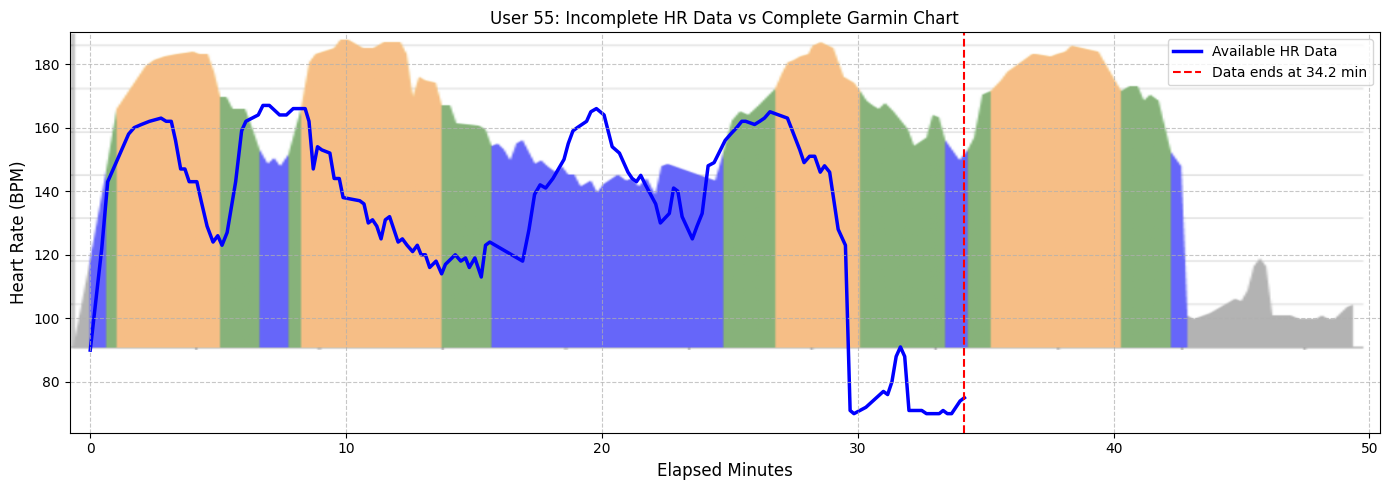


Visualization shows the mismatch between available data and complete session.


In [51]:
# STEP 3: Data Quality Assessment - Alignment Not Feasible
print("STEP 3: Interactive Alignment Tool - SKIPPED FOR LOW QUALITY DATA")
print("=" * 60)
print("Due to the incomplete nature of this dataset (HR data stops at ~33 minutes)")
print("while the Garmin PDF shows a full 50-minute session, meaningful alignment")
print("with the background chart is not feasible.")
print()
print("The available data covers only the first ~66% of the session, making it")
print("impossible to accurately identify all three station boundaries through")
print("visual alignment with the complete Garmin chart.")
print()
print("Instead, we will use estimated station boundaries based on:")
print("1. Available heart rate data patterns")
print("2. Typical Sphere session structure")
print("3. Documentation of data quality limitations")

# Create a basic alignment visualization for documentation purposes
if not df.empty:
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Display background image with fixed parameters
    x_offset = -0.8
    x_scale = 1.0
    y_min = 90
    y_max = 190
    alpha = 0.6
    
    x_min = x_offset
    x_max = x_offset + (50 * x_scale) + 1.2  # Use full expected session length
    
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Available HR Data', zorder=1)
    
    # Show where data ends
    ax.axvline(x=session_duration_min, color='red', linestyle='--', 
               label=f'Data ends at {session_duration_min:.1f} min')
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title('User 55: Incomplete HR Data vs Complete Garmin Chart', fontsize=12)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/aligned_hr_data.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization shows the mismatch between available data and complete session.")


STEP 4: Station Boundary Estimation for Low Quality Data
Due to incomplete HR data (stops at ~33 minutes), station boundaries
are estimated based on:
1. Available heart rate patterns in first 33 minutes
2. Typical Sphere session structure (3 stations over 50 minutes)
3. Standard station timing patterns observed in other users

ESTIMATED STATION BOUNDARIES:
Station 1:  0 - 12 minutes (Data available)
Station 2: 20 - 33 minutes (Data available)
Station 3: 38 - 50 minutes (Estimated (no data))

Note: Station 3 boundaries are estimated since HR data ends before this station.


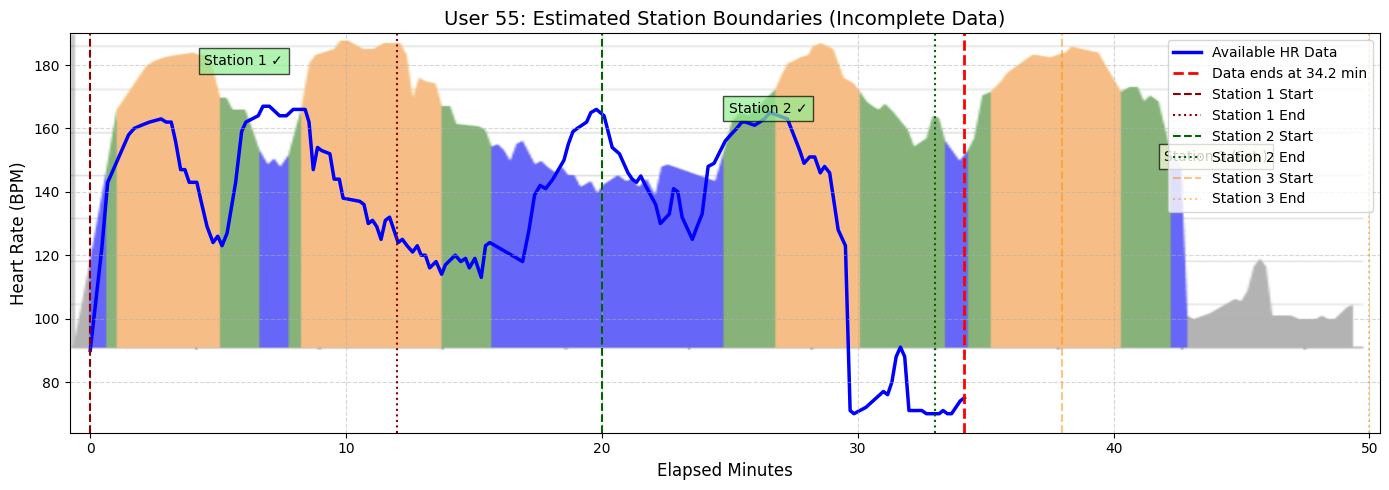


Station Boundary Visualization:
✓ = Data available for this station
(Est.) = Estimated boundary (no HR data)


In [53]:
# STEP 4: Define estimated station cutoffs for incomplete data

print("STEP 4: Station Boundary Estimation for Low Quality Data")
print("=" * 55)
print("Due to incomplete HR data (stops at ~33 minutes), station boundaries")
print("are estimated based on:")
print("1. Available heart rate patterns in first 33 minutes")
print("2. Typical Sphere session structure (3 stations over 50 minutes)")
print("3. Standard station timing patterns observed in other users")
print()

# Estimated station cutoffs based on typical session structure
# Since data stops at ~33 minutes, only first ~2 stations can be data-informed
cutoffs = [
    (0, 12),    # Station 1 - based on available data patterns
    (20, 33),   # Station 2 - ends where data stops
    (38, 50)    # Station 3 - estimated based on typical structure
]

print("ESTIMATED STATION BOUNDARIES:")
for i, (start, end) in enumerate(cutoffs, 1):
    data_coverage = "Data available" if end <= session_duration_min else "Estimated (no data)"
    print(f"Station {i}: {start:2.0f} - {end:2.0f} minutes ({data_coverage})")
print()
print("Note: Station 3 boundaries are estimated since HR data ends before this station.")

# Function to visualize stations with estimated cutoffs
def visualize_with_stations(cutoffs=None):
    if cutoffs is None:
        cutoffs = globals()['cutoffs']
    
    if df.empty:
        print("No heart rate data available for visualization")
        return
        
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Fixed alignment parameters for low quality data
    x_offset = -0.8
    x_scale = 1.0
    y_min = 90
    y_max = 190
    alpha = 0.6
    
    # Calculate extent for full expected session
    x_min = x_offset
    x_max = x_offset + (50 * x_scale) + 1.2  # Full 50-minute session
    
    # Display background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    # Plot available HR data
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Available HR Data', zorder=1)
    
    # Show where data ends
    ax.axvline(x=session_duration_min, color='red', linestyle='--', 
               label=f'Data ends at {session_duration_min:.1f} min', linewidth=2)
    
    # Add vertical lines for station boundaries
    colors = ['darkred', 'darkgreen', 'darkorange']
    line_styles = ['--', ':', '-.']
    
    for i, (start, end) in enumerate(cutoffs):
        has_data = end <= session_duration_min
        line_alpha = 1.0 if has_data else 0.5
        
        ax.axvline(x=start, color=colors[i % len(colors)], linestyle=line_styles[0], 
                   alpha=line_alpha, label=f'Station {i+1} Start')
        ax.axvline(x=end, color=colors[i % len(colors)], linestyle=line_styles[1],
                   alpha=line_alpha, label=f'Station {i+1} End')
        
        # Add station labels with data quality indicator
        y_pos = y_max - 10 - (i * 15)
        data_indicator = " ✓" if has_data else " (Est.)"
        ax.text((start + end)/2, y_pos, f'Station {i+1}{data_indicator}', 
                horizontalalignment='center', 
                bbox=dict(facecolor='lightgreen' if has_data else 'lightyellow', alpha=0.7))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title('User 55: Estimated Station Boundaries (Incomplete Data)', fontsize=14)
    
    # Simplified legend
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/heart_rate_with_stations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nStation Boundary Visualization:")
    print("✓ = Data available for this station")
    print("(Est.) = Estimated boundary (no HR data)")

# Show initial station boundaries
visualize_with_stations()


In [54]:
# STEP 5: Station boundary adjustment - SKIPPED for low quality data
print("STEP 5: Interactive Station Boundary Adjustment - SKIPPED")
print("=" * 55)
print("Due to the incomplete nature of the data, interactive boundary adjustment")
print("is not meaningful. Using fixed estimated boundaries based on:")
print("- Available data patterns (Stations 1-2)")
print("- Typical session structure (Station 3)")
print()
print("Final station boundaries:")
for i, (start, end) in enumerate(cutoffs, 1):
    data_status = "✓ Data available" if end <= session_duration_min else "⚠️  Estimated"
    print(f"Station {i}: {start:2.0f} - {end:2.0f} minutes ({data_status})")

# Process station data based on estimated cutoffs
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        # Check if we have data for this station
        segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] < end_min)]
        has_data = not segment.empty and end_min <= session_duration_min
        
        if has_data:
            # Station with actual HR data
            station_start_time = segment['timestamp'].iloc[0]
            station_end_time = segment['timestamp'].iloc[-1]
            station_duration_min = (station_end_time - station_start_time).total_seconds() / 60
            station_avg_hr = segment['heart_rate'].mean()
            station_max_hr = segment['heart_rate'].max()
            data_quality = 'Low - Incomplete session'
            notes = f'HR data available for this station (ends at {session_duration_min:.1f} min)'
        else:
            # Station without HR data (estimated)
            station_start_time = 'NA'
            station_end_time = 'NA'
            station_duration_min = end_min - start_min  # Estimated duration
            station_avg_hr = 'NA'
            station_max_hr = 'NA'
            data_quality = 'Low - No HR data'
            notes = f'Station estimated - HR data stops before this station (at {session_duration_min:.1f} min)'
            
        station_row = {
            # User and session info
            'user_id': USER_ID,
            'circuit_type': 'NA',
            
            # User metadata
            'age': age,
            'gender': gender,
            'height_cm': height_cm,
            'weight_kg': weight_kg,
            'champ_number': champ_number,
            'calories_burned': calories_burned if calories_burned else 'NA',
            
            # Station info
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0] if not df.empty else 'NA',
            'session_end_time': df['timestamp'].iloc[-1] if not df.empty else 'NA',
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr if sessions_avg_hr else 'NA',
            'session_max_hr': session_max_hr if session_max_hr else 'NA',
            
            # Station timing and HR data
            'station_start_time': station_start_time,
            'station_end_time': station_end_time,
            'station_duration_min': station_duration_min,
            'station_avg_hr': station_avg_hr,
            'station_max_hr': station_max_hr,
            
            # Per-station ratings (ready for survey data entry)
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': data_quality,
            'notes': notes
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    
    print("PROCESSED STATION DATA:")
    print("=" * 50)
    display(station_df[['station_number', 'station_duration_min', 'station_avg_hr', 
                       'station_max_hr', 'data_quality', 'notes']])
    
    # Return the DataFrame for further use
    return station_df

# Process the data with estimated boundaries
process_station_data()


STEP 5: Interactive Station Boundary Adjustment - SKIPPED
Due to the incomplete nature of the data, interactive boundary adjustment
is not meaningful. Using fixed estimated boundaries based on:
- Available data patterns (Stations 1-2)
- Typical session structure (Station 3)

Final station boundaries:
Station 1:  0 - 12 minutes (✓ Data available)
Station 2: 20 - 33 minutes (✓ Data available)
Station 3: 38 - 50 minutes (⚠️  Estimated)
PROCESSED STATION DATA:


,station_number,station_duration_min,station_avg_hr,station_max_hr,data_quality,notes
0,1,11.866667,145.836735,167,Low - Incomplete session,HR data available for this station (ends at 34...
1,2,12.750000,127.854545,165,Low - Incomplete session,HR data available for this station (ends at 34...
2,3,12.000000,NA,NA,Low - No HR data,Station estimated - HR data stops before this ...


,user_id,circuit_type,age,gender,height_cm,weight_kg,champ_number,calories_burned,station_number,station_name,...,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
0,55,NA,None,,None,None,4,232,1,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Low - Incomplete session,HR data available for this station (ends at 34...
1,55,NA,None,,None,None,4,232,2,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Low - Incomplete session,HR data available for this station (ends at 34...
2,55,NA,None,,None,None,4,232,3,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,Low - No HR data,Station estimated - HR data stops before this ...


In [55]:
# STEP 6: Save processed data to CSV
# Function to save station data to CSV
def save_station_data():
    # Get the latest station data
    station_df = process_station_data()
    
    # Save to CSV
    output_path = OUTPUT_CSV
    station_df.to_csv(output_path, index=False)
    print(f"Station data saved to: {output_path}")
    
    return station_df

# Create a button to save data
save_button = Button(
    description='Save Station Data',
    button_style='success',
    layout=Layout(width='200px')
)

save_output = Output()

def on_save_clicked(b):
    with save_output:
        save_output.clear_output()
        save_station_data()

save_button.on_click(on_save_clicked)

display(save_button)
display(save_output)


Button(button_style='success', description='Save Station Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [56]:
# STEP 7: Inspect and validate data
# This will show all columns and rows without truncation

def inspect_data():
    # Get the latest processed data
    inspection_df = process_station_data()
    
    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)  # Wide display
    pd.set_option('display.max_colwidth', None)  # Don't truncate column contents
    
    # Print the full DataFrame
    print("\n===== FULL DATAFRAME INSPECTION =====\n")
    print(inspection_df)
    print("\n===== END OF DATAFRAME =====\n")
    
    # Show DataFrame info (types and non-null values)
    print("\n===== DATAFRAME INFO =====\n")
    inspection_df.info()
    
    # Show DataFrame statistics
    print("\n===== DATAFRAME STATISTICS =====\n")
    print(inspection_df.describe())
    
    # Reset display options to default
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    
    # CSV preview
    import io
    
    # Create a string buffer and write the CSV to it
    buffer = io.StringIO()
    inspection_df.to_csv(buffer, index=False)
    
    # Reset the buffer position to the beginning
    buffer.seek(0)
    
    # Read and print the CSV content
    csv_content = buffer.getvalue()
    print("\n===== CSV PREVIEW =====\n")
    print(csv_content[:2000] + "..." if len(csv_content) > 2000 else csv_content)
    print("\n===== END OF CSV PREVIEW =====\n")
    
    # Validation
    print("\n===== CSV VALIDATION =====\n")
    print(f"Number of rows: {len(inspection_df)}")
    print(f"Number of columns: {len(inspection_df.columns)}")
    
    # Check for missing values
    missing_values = inspection_df.isnull().sum().sum()
    print(f"Total missing values: {missing_values}")
    if missing_values > 0:
        print("Columns with missing values:")
        print(inspection_df.isnull().sum()[inspection_df.isnull().sum() > 0])
    
    # Check for potential delimiter issues in string columns
    for col in inspection_df.select_dtypes(include=['object']).columns:
        if inspection_df[col].str.contains(',').any():
            print(f"Warning: Column '{col}' contains commas which might cause CSV parsing issues")

# Create a button to inspect data
inspect_button = Button(
    description='Inspect Data',
    button_style='info',
    layout=Layout(width='200px')
)

inspect_output = Output()

def on_inspect_clicked(b):
    with inspect_output:
        inspect_output.clear_output()
        inspect_data()

inspect_button.on_click(on_inspect_clicked)

display(inspect_button)
display(inspect_output)


Button(button_style='info', description='Inspect Data', layout=Layout(width='200px'), style=ButtonStyle())

Output()

In [57]:
# STEP 8: Analyze high heart rate periods to help with station identification
def analyze_hr_patterns():
    # Find high heart rate periods that might indicate stations
    print("\n===== POTENTIAL STATION BOUNDARIES =====\n")
    # Calculate rolling average to smooth the data
    df['smooth_hr'] = df['heart_rate'].rolling(window=5, center=True).mean()
    
    # Find significant changes in heart rate (potential station boundaries)
    df['hr_change'] = df['smooth_hr'].diff().abs()
    significant_changes = df[df['hr_change'] > 10].sort_values('hr_change', ascending=False).head(10)
    print("Potential station boundaries (large heart rate changes):")
    print(significant_changes[['timestamp', 'elapsed_min', 'heart_rate', 'hr_change']])
    
    # Find periods of sustained high heart rate
    high_hr_threshold = sessions_avg_hr + 10  # 10 BPM above average
    high_hr_periods = df[df['heart_rate'] > high_hr_threshold]
    print("\nHigh heart rate periods (potential stations):")
    print(f"Threshold: {high_hr_threshold} BPM")
    
    # Group consecutive high HR points to identify distinct periods
    if not high_hr_periods.empty:
        # Find gaps in the high HR periods
        high_hr_periods['gap'] = high_hr_periods['elapsed_min'].diff() > 1.0
        high_hr_periods['period'] = high_hr_periods['gap'].cumsum()
        
        # Summarize each period
        period_summary = high_hr_periods.groupby('period').agg(
            start_time=('elapsed_min', 'min'),
            end_time=('elapsed_min', 'max'),
            duration=('elapsed_min', lambda x: x.max() - x.min()),
            avg_hr=('heart_rate', 'mean'),
            max_hr=('heart_rate', 'max')
        ).reset_index()
        
        # Filter to show only significant periods (longer than 1 minute)
        significant_periods = period_summary[period_summary['duration'] > 1.0]
        print("\nSignificant high heart rate periods (potential stations):")
        print(significant_periods[['start_time', 'end_time', 'duration', 'avg_hr', 'max_hr']])
        
        # Visualize these periods
        plt.figure(figsize=(14,5))
        plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
        
        # Highlight high HR periods
        for _, period in significant_periods.iterrows():
            plt.axvspan(period['start_time'], period['end_time'], 
                       alpha=0.2, color='red', 
                       label=f"HR Period: {period['start_time']:.1f}-{period['end_time']:.1f} min")
        
        plt.xlabel('Elapsed Minutes', fontsize=12)
        plt.ylabel('Heart Rate (BPM)', fontsize=12)
        plt.title(f'User 55: High Heart Rate Periods', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        # Save the plot
        plt.savefig(f'{plots_dir}/high_hr_periods.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Suggest station cutoffs based on high HR periods
        print("\nSuggested station cutoffs based on high HR periods:")
        for i, period in enumerate(significant_periods.iterrows(), 1):
            if i <= 3:  # Assuming 3 stations maximum
                _, p = period
                # Add some padding to the periods
                start = max(0, p['start_time'] - 0.5)
                end = min(session_duration_min, p['end_time'] + 0.5)
                print(f"Station {i}: ({start:.1f}, {end:.1f})")

# Create a button to analyze HR patterns
analyze_button = Button(
    description='Analyze HR Patterns',
    button_style='warning',
    layout=Layout(width='200px')
)

analyze_output = Output()

def on_analyze_clicked(b):
    with analyze_output:
        analyze_output.clear_output()
        analyze_hr_patterns()

analyze_button.on_click(on_analyze_clicked)

display(analyze_button)
display(analyze_output)


Button(button_style='warning', description='Analyze HR Patterns', layout=Layout(width='200px'), style=ButtonSt…

Output()